# SLALOM Supplementary Figures 
## ABF as a function of sample size

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import logsumexp
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend

In [2]:
matplotlib.rc('font', family='Helvetica') 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## ABF, varying marginal effect size and sample size

In [3]:
# this is the inverse of the ABF defined on p.3 of Wakefield 2007. They define p(betahat|H_0) / p(betahat|H_1)

def compute_bf(n, betahat, sigma0_2, sigma_2):
    s2 = sigma_2 / n
    return np.sqrt(s2 / (sigma0_2 + s2)) * np.exp(0.5 * betahat**2 * sigma0_2 / (sigma0_2 + s2) / s2)

In [4]:
class TextHandlerA(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(
            width/2.,height/2, artist.get_text(), fontsize=fontsize,
            ha="center", va="center", color="grey"
        )
        return [tx]

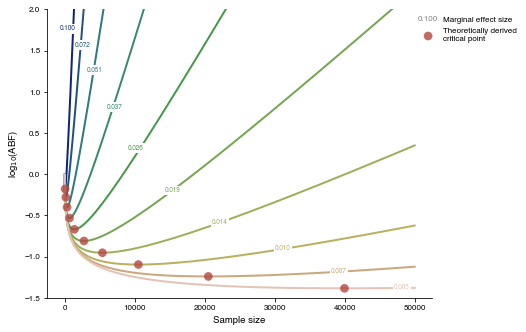

In [5]:
# varying betahat
f, ax = plt.subplots(figsize=(7.2, 4.5), constrained_layout=True)

sigma_2 = 1
sigma0_2 = 0.04
betahats = np.geomspace(0.1, 0.005, 10)
colors = list(reversed(sns.color_palette(palette="gist_earth_r", n_colors=len(betahats))))
text_positions = [
    (-700, 1.75),
    (1500, 1.55),
    (3100, 1.25),
    (6000, 0.8),
    (9000, 0.3),
    (14300, -0.21),
    (21000, -0.6),
    (30000, -0.91),
    (38000, -1.19),
    (47000, -1.39)
]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

n = np.arange(1, 50000)
for i, betahat in enumerate(betahats):
    
    bf = compute_bf(n, betahat, sigma0_2, sigma_2) 
    ax.plot(n, np.log10(bf), color=colors[i], linewidth=2)
    ax.annotate(
        f"{betahat:.3f}",
        text_positions[i], 
        fontsize=6.4,
        fontname="Helvetica",
        color=colors[i],
        bbox={"facecolor":"white", "edgecolor":"white", "boxstyle":"square,pad=0.15"}
    )
    
    # variables for quadratic formula
    a = sigma0_2 / sigma_2
    b = 2 - (sigma0_2 / (betahat**2))
    c = (sigma_2 / sigma0_2) - ((sigma_2**2) / sigma0_2) - (sigma_2 / (betahat**2))

    # the larger root, the only root we care about
    root = (-b + np.sqrt(b**2 - (4*a*c))) / (2*a) 
    if root < n.max():
        red_dot = ax.scatter(
            [root], [np.log10(compute_bf(root, betahat, sigma0_2, sigma_2))], 
            s=75, c="#b5463e", zorder=100, alpha=0.8, edgecolors="none"
        )
        
ax.set_ylim(bottom=-1.5, top=2)
ax.set_xlabel("Sample size", fontsize=9.6)

ax.set_ylabel(r"$\mathregular{log}_{10}$(ABF)", fontsize=9.6)
proxy_text = Text([], [], "0.100", fontsize=6.4, color="grey")
ax.legend(
    [proxy_text, red_dot], 
    ["Marginal effect size", "Theoretically derived\ncritical point"], 
    bbox_to_anchor=(0.95 ,1), frameon=False, fontsize=8,
    handler_map={proxy_text: TextHandlerA()}
)
ax.tick_params(labelsize=8)

plt.savefig("fig1.pdf", dpi=300)

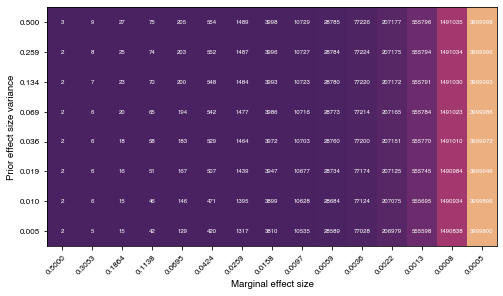

In [6]:
# heatmap

betahats = np.geomspace(0.5, 0.0005, 15)
sigma0_2s = np.geomspace(0.5, 0.005, 8)
sigma_2 = 1

n_crits = np.zeros((len(sigma0_2s), len(betahats)))

for i, sigma0_2 in enumerate(sigma0_2s):
    for j, betahat in enumerate(betahats):
        
        a = -(betahat**2) * (sigma0_2**2) / sigma_2
        b = (sigma0_2**2) - (2 * (betahat**2) * sigma0_2)
        c = (sigma0_2 * sigma_2) + ((betahat**2) * (sigma_2**2)) - ((betahat**2) * sigma_2)
        n_crit = (-b - np.sqrt(b**2 - (4*a*c))) / (2*a)
        
        n_crits[i, j] = n_crit
        
f, ax = plt.subplots(figsize=(7.2, 4), constrained_layout=True)
im = ax.imshow(n_crits, cmap=sns.color_palette("flare_r", as_cmap=True))

ax.set_xticks(np.arange(len(betahats)))
ax.set_xticklabels([f"{betahat:.4f}" for betahat in betahats], fontsize=8)
ax.set_yticks(np.arange(len(sigma0_2s)))
ax.set_yticklabels([f"{sigma0_2:.3f}" for sigma0_2 in sigma0_2s], fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(sigma0_2s)):
    for j in range(len(betahats)):
        text = ax.text(j, i, int(round(n_crits[i, j])), ha="center", va="center", color="w", fontsize=6)

ax.set_xlabel("Marginal effect size", fontsize=9.6)
_ = ax.set_ylabel("Prior effect size variance", fontsize=9.6)

plt.savefig("fig2.pdf", dpi=300)

## Two-SNP simulation

In [7]:
rng = np.random.default_rng(1234)

In [8]:
def abf(z, s2, sigma0_2=0.04):
    """calculate Approximate Bayes Factors and PIPs from z-scores"""

    r = sigma0_2 / (sigma0_2 + s2)
    lBF = 0.5 * (np.log(1 - r) + (r * (z ** 2)))
    PIP = np.exp(lBF - logsumexp(lBF))
    return lBF, PIP

### Simulation 1 - two SNPs in LD, one causal

In [9]:
# comparing PIP for SNP B when no samples missing vs. some samples missing

nsim = 1000
b = 0.01
n = 50000
n_sub = 30000

lBFs = []
lBFs_missing = []
pips = []
pips_missing = []

for i in range(nsim):
    x = rng.multivariate_normal([0,0], [[1, 0.9], [0.9, 1]], size=n)

    x_A = x[:, 0]
    x_B = x[:, 1]
    x_B_missing = x[:n_sub, 1]

    eps = rng.normal(loc=0, scale=1, size=n)

    y = x_B * b + eps

    bhat_A = (x_A.T @ y) / (x_A.T @ x_A) # estimated coefficient
    sigma2_hat_A = np.var(y - (x_A * bhat_A)) # estimated residual variance
    s2_A = sigma2_hat_A / (x_A.T @ x_A) # squared standard error
    z_A = bhat_A / np.sqrt(s2_A) # z score

    bhat_B = (x_B.T @ y) / (x_B.T @ x_B)
    sigma2_hat_B = np.var(y - (x_B * bhat_B))
    s2_B = sigma2_hat_B / (x_B.T @ x_B)
    z_B = bhat_B / np.sqrt(s2_B)

    bhat_B_missing = (x_B_missing.T @ y[:n_sub]) / (x_B_missing.T @ x_B_missing)
    sigma2_hat_B_missing = np.var(y[:n_sub] - (x_B_missing * bhat_B_missing))
    s2_B_missing = sigma2_hat_B_missing / (x_B_missing.T @ x_B_missing)
    z_B_missing = bhat_B_missing / np.sqrt(s2_B_missing)

    lBF, pip = abf(np.array([z_A, z_B]), np.array([s2_A, s2_B]))
    lBF_missing, pip_missing = abf(np.array([z_A, z_B_missing]), np.array([s2_A, s2_B_missing]))

    pips.append(pip[1])
    pips_missing.append(pip_missing[1])
    lBFs.append(lBF[1])
    lBFs_missing.append(lBF_missing[1])

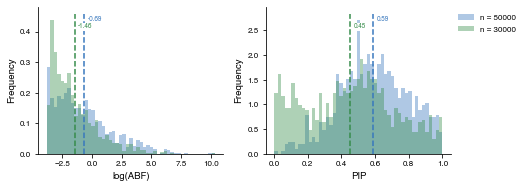

In [10]:
f, ax = plt.subplots(1, 2, figsize=(7.2, 2.5), constrained_layout=True)

blue = "#3777bd"
green = "#358c4a"

# plot BFs
a = ax[0]
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
bins = np.linspace(
    min(lBFs + lBFs_missing),
    max(lBFs + lBFs_missing),
    num=50
)
bin_width = bins[1] - bins[0]
a.hist(lBFs, bins=bins, density=True, color=blue, alpha=0.4, label=f"n = {n}")
a.hist(lBFs_missing, bins=bins, density=True, color=green, alpha=0.4, label=f"n = {n_sub}")
ymin, ymax = a.get_ylim()
a.vlines(np.mean(lBFs), ymin, ymax, linestyles="dashed", colors=blue)
a.annotate(
    f"{np.mean(lBFs):.2f}", 
    (np.mean(lBFs) + bin_width, ymax * 0.95), 
    fontsize=6.4,
    color=blue,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.vlines(np.mean(lBFs_missing), ymin, ymax, linestyles="dashed", colors=green)
a.annotate(
    f"{np.mean(lBFs_missing):.2f}", 
    (np.mean(lBFs_missing) + bin_width, ymax * 0.9), 
    fontsize=6.4,
    color=green,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.set_ylabel("Frequency", fontsize=9.6)
a.set_xlabel("log(ABF)", fontsize=9.6)
a.tick_params(labelsize=8)

# plot PIPs
a = ax[1]
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
bins = np.linspace(
    min(pips + pips_missing),
    max(pips + pips_missing),
    num=50
)
bin_width = bins[1] - bins[0]
a.hist(pips, bins=bins, density=True, color=blue, alpha=0.4, label=f"n = {n}")
a.hist(pips_missing, bins=bins, density=True, color=green, alpha=0.4, label=f"n = {n_sub}")
ymin, ymax = a.get_ylim()
a.vlines(np.mean(pips), ymin, ymax, linestyles="dashed", colors=blue)
a.annotate(
    f"{np.mean(pips):.2f}", 
    (np.mean(pips) + bin_width, ymax * 0.95), 
    fontsize=6.4,
    color=blue,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.vlines(np.mean(pips_missing), ymin, ymax, linestyles="dashed", colors=green)
a.annotate(
    f"{np.mean(pips_missing):.2f}", 
    (np.mean(pips_missing) + bin_width, ymax * 0.9), 
    fontsize=6.4,
    color=green,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, fontsize=8)
a.set_ylabel("Frequency", fontsize=9.6)
a.set_xlabel("PIP", fontsize=9.6)
a.tick_params(labelsize=8)

plt.savefig("fig3.pdf", dpi=300)

### Simulation 2 - two SNPs in perfect LD with different sample sizes

In [11]:
nsim = 1000
b = 0.01
n = 50000
n_A = n
n_B = 30000

lBFs_A = []
lBFs_B = []
pips_A = []
pips_B = []

for i in range(nsim):
    x = rng.normal(size=n)

    x_A = x
    x_B = x[:n_B]

    eps = rng.normal(loc=0, scale=1, size=n)

    y = x_A * b + eps
    y_A = y
    y_B = y[:n_B]

    bhat_A = (x_A.T @ y_A) / (x_A.T @ x_A) # estimated coefficient
    sigma2_hat_A = np.var(y_A - (x_A * bhat_A)) # estimated residual variance
    s2_A = sigma2_hat_A / (x_A.T @ x_A) # squared standard error
    z_A = bhat_A / np.sqrt(s2_A) # z score

    bhat_B = (x_B.T @ y_B) / (x_B.T @ x_B)
    sigma2_hat_B = np.var(y_B - (x_B * bhat_B))
    s2_B = sigma2_hat_B / (x_B.T @ x_B)
    z_B = bhat_B / np.sqrt(s2_B)

    lBF, pip = abf(np.array([z_A, z_B]), np.array([s2_A, s2_B]))
    
    lBFs_A.append(lBF[0])
    lBFs_B.append(lBF[1])
    pips_A.append(pip[0])
    pips_B.append(pip[1])

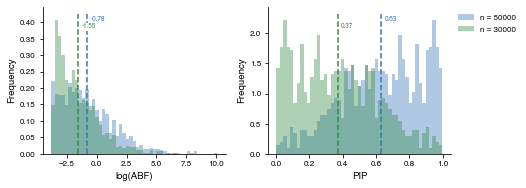

In [12]:
f, ax = plt.subplots(1, 2, figsize=(7.2, 2.5), constrained_layout=True)

blue = "#3777bd"
green = "#358c4a"

# plot BFs
a = ax[0]
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
bins = np.linspace(
    min(lBFs_A + lBFs_B),
    max(lBFs_A + lBFs_B),
    num=50
)
bin_width = bins[1] - bins[0]
a.hist(lBFs_A, bins=bins, density=True, color=blue, alpha=0.4, label=f"n = {n}")
a.hist(lBFs_B, bins=bins, density=True, color=green, alpha=0.4, label=f"n = {n_sub}")
ymin, ymax = a.get_ylim()
a.vlines(np.mean(lBFs_A), ymin, ymax, linestyles="dashed", colors=blue)
a.annotate(
    f"{np.mean(lBFs_A):.2f}", 
    (np.mean(lBFs_A) + bin_width, ymax * 0.95), 
    fontsize=6.4,
    color=blue,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.vlines(np.mean(lBFs_B), ymin, ymax, linestyles="dashed", colors=green)
a.annotate(
    f"{np.mean(lBFs_B):.2f}", 
    (np.mean(lBFs_B) + bin_width, ymax * 0.9), 
    fontsize=6.4,
    color=green,
    bbox={"facecolor":"white", "edgecolor":"white", "pad":0.25}
)
a.set_ylabel("Frequency", fontsize=9.6)
a.set_xlabel("log(ABF)", fontsize=9.6)
a.tick_params(labelsize=8)

# plot PIPs
a = ax[1]
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
bins = np.linspace(
    min(pips_A + pips_B),
    max(pips_A + pips_B),
    num=50
)
bin_width = bins[1] - bins[0]
a.hist(pips_A, bins=bins, density=True, color=blue, alpha=0.4, label=f"n = {n}")
a.hist(pips_B, bins=bins, density=True, color=green, alpha=0.4, label=f"n = {n_sub}")
ymin, ymax = a.get_ylim()
a.vlines(np.mean(pips_A), ymin, ymax, linestyles="dashed", colors=blue)
a.annotate(
    f"{np.mean(pips_A):.2f}", 
    (np.mean(pips_A) + bin_width, ymax * 0.95), 
    fontsize=6.4,
    color=blue,
    bbox={"facecolor":"white", "edgecolor":"white", "pad": 0.25}
)
a.vlines(np.mean(pips_B), ymin, ymax, linestyles="dashed", colors=green)
a.annotate(
    f"{np.mean(pips_B):.2f}", 
    (np.mean(pips_B) + bin_width, ymax * 0.9), 
    fontsize=6.4,
    color=green,
    bbox={"facecolor":"white", "edgecolor":"white", "pad": 0.25}
)
a.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, fontsize=8)
a.set_ylabel("Frequency", fontsize=9.6)
a.set_xlabel("PIP", fontsize=9.6)
a.tick_params(labelsize=8)

plt.savefig("fig4.pdf", dpi=300)

## Appendix

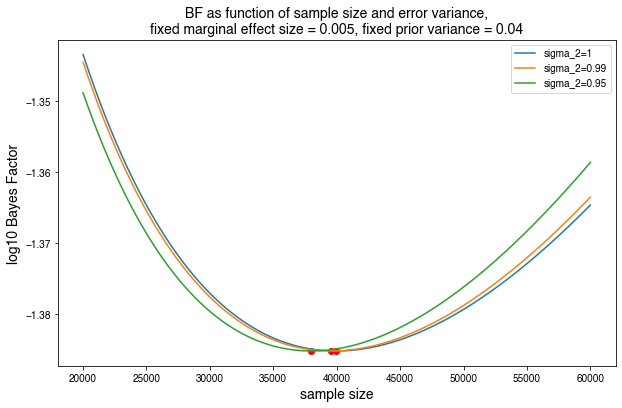

In [13]:
# varying sigma2

sigma_2s = [1, 0.99, 0.95]
sigma0_2 = 0.04
betahat = 0.005

plt.figure(figsize=(10, 6))

n = np.arange(20000, 60000)
for sigma_2 in sigma_2s:
    
    bf = compute_bf(n, betahat, sigma0_2, sigma_2) 
    plt.plot(n, np.log10(bf), label=f"sigma_2={sigma_2}")
    
    # variables for quadratic formula
    a = -(betahat**2) * (sigma0_2**2) / sigma_2
    b = (sigma0_2**2) - (2 * (betahat**2) * sigma0_2)
    c = (sigma0_2 * sigma_2) + ((betahat**2) * (sigma_2**2)) - ((betahat**2) * sigma_2)

    root = (-b - np.sqrt(b**2 - (4*a*c))) / (2*a)
    if root < n.max():
        plt.scatter([root], [np.log10(compute_bf(root, betahat, sigma0_2, sigma_2))], c="red")
        
plt.xlabel("sample size", fontsize=14)
plt.ylabel("log10 Bayes Factor", fontsize=14)
plt.title(
    f"BF as function of sample size and error variance,\n" +
    f"fixed marginal effect size = {betahat}, fixed prior variance = {sigma0_2}", 
    fontsize=14
)    
plt.legend(bbox_to_anchor=(1,1))